In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt

In [2]:
data_path = "data/"
#Load OECD Better Life Index data.
bli_df = pd.read_csv(data_path + "oecd_bli_2015.csv")
#Load IMF GDP per capita data.
#Encoding is different from Unicode, so Unicode based decoding won't work.
#Have to use latin1
#Use thousands to remove comma in GDP field.
gdp_df = pd.read_csv(data_path + "gdp_per_capita.csv", delimiter="\t", encoding="latin1", thousands=",")

In [3]:
#See the BLI data.
bli_df.head(2)

,LOCATION,Country,INDICATOR,Indicator,MEASURE,Measure,INEQUALITY,Inequality,Unit Code,Unit,PowerCode Code,PowerCode,Reference Period Code,Reference Period,Value,Flag Codes,Flags
0,AUS,Australia,HO_BASE,Dwellings without basic facilities,L,Value,TOT,Total,PC,Percentage,0,units,NaN,NaN,1.1,E,Estimated value
1,AUT,Austria,HO_BASE,Dwellings without basic facilities,L,Value,TOT,Total,PC,Percentage,0,units,NaN,NaN,1.0,NaN,NaN


In [4]:
#See the GDP data.
gdp_df.head(2)

,Country,Subject Descriptor,Units,Scale,Country/Series-specific Notes,2015,Estimates Start After
0,Afghanistan,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",599.994,2013.0
1,Albania,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",3995.383,2010.0


In [5]:
#Check if 'Country' field qualifies as a primary key for join.
print("Country field in BLI Table is a Primary Key : ", ~bli_df["Country"].duplicated().any())
print("Country field in GDP Table is a Primary Key : ", ~gdp_df["Country"].duplicated().any())

Country field in BLI Table is a Primary Key :  False
Country field in GDP Table is a Primary Key :  True


In [6]:
#Check why 'Country' is not a proper primary key.
bli_df["Country"].value_counts()

Turkey             90
Finland            90
Switzerland        90
Russia             90
Hungary            90
Italy              90
Ireland            90
New Zealand        90
Czech Republic     90
Mexico             90
Iceland            90
Estonia            90
Poland             90
Greece             90
Slovak Republic    90
Sweden             90
Japan              90
Norway             90
Korea              90
Chile              90
Portugal           90
Canada             89
Australia          89
Luxembourg         89
France             89
Germany            89
Spain              89
United Kingdom     89
Austria            89
Slovenia           88
Denmark            88
Belgium            88
Netherlands        88
United States      88
Israel             88
Brazil             88
OECD - Total       74
Name: Country, dtype: int64

In [7]:
#Check why multiple entries against same "Country" value.
bli_df[bli_df["Country"] == "Australia"]

,LOCATION,Country,INDICATOR,Indicator,MEASURE,Measure,INEQUALITY,Inequality,Unit Code,Unit,PowerCode Code,PowerCode,Reference Period Code,Reference Period,Value,Flag Codes,Flags
0,AUS,Australia,HO_BASE,Dwellings without basic facilities,L,Value,TOT,Total,PC,Percentage,0,units,NaN,NaN,1.10,E,Estimated value
37,AUS,Australia,HO_BASE,Dwellings without basic facilities,L,Value,MN,Men,PC,Percentage,0,units,NaN,NaN,1.10,E,Estimated value
73,AUS,Australia,HO_BASE,Dwellings without basic facilities,L,Value,WMN,Women,PC,Percentage,0,units,NaN,NaN,1.10,E,Estimated value
109,AUS,Australia,HO_HISH,Housing expenditure,L,Value,TOT,Total,PC,Percentage,0,units,NaN,NaN,20.00,NaN,NaN
146,AUS,Australia,HO_HISH,Housing expenditure,L,Value,MN,Men,PC,Percentage,0,units,NaN,NaN,20.00,E,Estimated value
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3107,AUS,Australia,WL_EWLH,Employees working very long hours,L,Value,MN,Men,PC,Percentage,0,units,NaN,NaN,20.67,NaN,NaN
3144,AUS,Australia,WL_EWLH,Employees working very long hours,L,Value,WMN,Women,PC,Percentage,0,units,NaN,NaN,6.50,NaN,NaN
3181,AUS,Australia,WL_TNOW,Time devoted to leisure and personal care,L,Value,TOT,Total,HOUR,Hours,0,units,NaN,NaN,14.41,NaN,NaN
3218,AUS,Australia,WL_TNOW,Time devoted to leisure and personal care,L,Value,MN,Men,HOUR,Hours,0,units,NaN,NaN,14.43,NaN,NaN


In [8]:
#Seems like there are multiple indicator values in the BLI dataset.
#Life satisfaction for each country is most probably uniquely defined by 
#INDICATOR="SW_LIFS" and INEQUALITY="TOT".
#Create an appropriate filter on these.
bli_filter = (bli_df["INDICATOR"] == "SW_LIFS") & (bli_df["INEQUALITY"] == "TOT")
#Check if filter applied BLI table has 'Country' field as valid primary key.
print("Filter applied BLI Table is a Primary Key : ", ~bli_df[bli_filter]["Country"].duplicated().any())

Filter applied BLI Table is a Primary Key :  True


In [9]:
#Select only relevant data before Join operation.
bli_df = bli_df[bli_filter]

In [10]:
#Do an Inner Join both Dataframes on 'Country' field and select relavent columns.
bli_gdp_df = pd.merge(bli_df, gdp_df, on="Country", how="inner")[["Country", "Value", "2015"]]
bli_gdp_df.head(2)

,Country,Value,2015
0,Australia,7.3,50961.865
1,Austria,6.9,43724.031


In [11]:
#Rename the column names to appropriately.
bli_gdp_df.rename(columns={"Value":"Better Life Index", "2015":"GDP per capita"}, inplace=True)
bli_gdp_df.head(2)

,Country,Better Life Index,GDP per capita
0,Australia,7.3,50961.865
1,Austria,6.9,43724.031


In [12]:
#Check if the dataframe is proper or not.
bli_gdp_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36 entries, 0 to 35
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Country            36 non-null     object 
 1   Better Life Index  36 non-null     float64
 2   GDP per capita     36 non-null     float64
dtypes: float64(2), object(1)
memory usage: 1.1+ KB


Text(0, 0.5, 'Better Life Index')

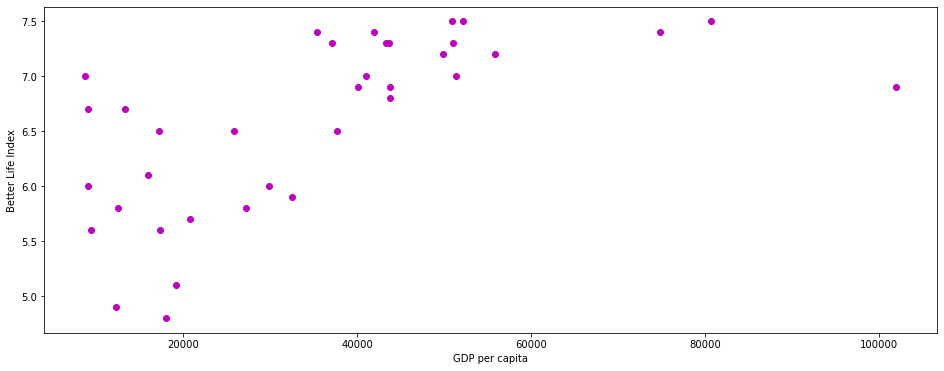

In [13]:
#Visualize the dataframe.
ax = bli_gdp_df.plot(x="GDP per capita", y="Better Life Index", style = "mo", figsize=(16,6), legend=False)
ax.set_ylabel("Better Life Index")

In [14]:
#Make the dataframe values as traditional X,y numpy arrays for sklearn.
X, y = bli_gdp_df["GDP per capita"].values.reshape(-1, 1), bli_gdp_df["Better Life Index"].values
#Split the dataset into test and train sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, shuffle=True)

In [15]:
#Train a linear Model on X_train and test on X_test.
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)
results = pd.DataFrame({"Original":y_test, "Predicted":y_pred})
results

,Original,Predicted
0,6.9,6.751589
1,7.3,6.597761


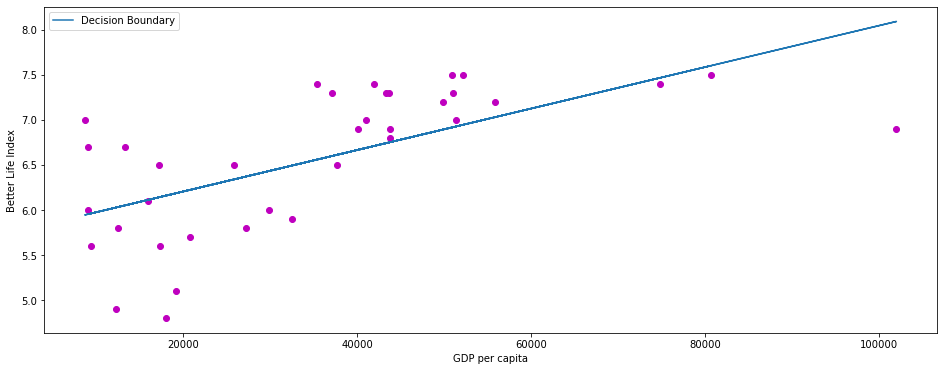

In [16]:
#Visualize the trained model.
fig, ax = plt.subplots(figsize=(16, 6))
ax.set_xlabel("GDP per capita")
ax.set_ylabel("Better Life Index")
ax.scatter(X.squeeze(), y, c='m')
ax.plot(X.squeeze(), lr_model.predict(X), label="Decision Boundary")
plt.legend()